In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, UpSampling2D
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape

C:\Users\super\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train[:5000].astype('float32') / 255.
x_test = x_test[:1000].astype('float32') / 255.
y_train = y_train[:5000]
y_test = y_test[:1000]

In [3]:
x_train = np.array([resize(img, (64, 64)) for img in x_train]).astype('float32')
x_test = np.array([resize(img, (64, 64)) for img in x_test]).astype('float32')

C:\Users\super\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
def salt_and_pepper(img):
    n_rows, n_cols, n_chann = img.shape
    for row in range(n_rows):
        for col in range(n_cols):
            thresh = np.random.rand()
            if thresh > 0.9:
                img[row, col, :] = 1
            elif thresh < 0.1:
                img[row, col, :] = 0
    return img

In [5]:
x_train_noise = np.array([salt_and_pepper(img.copy()) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy()) for img in x_test]).astype('float32')

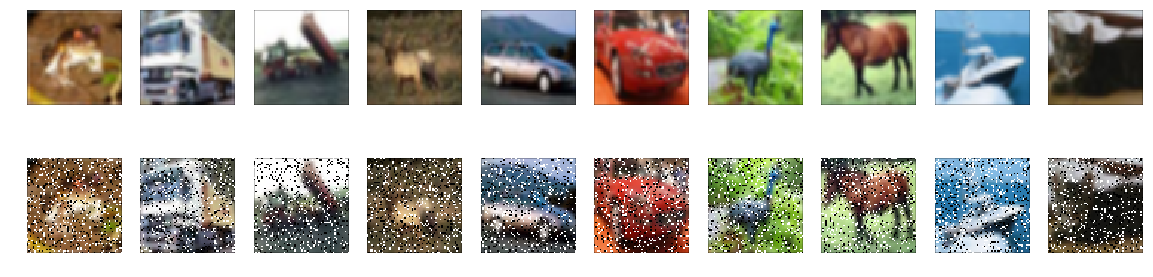

In [6]:
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_train[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_train_noise[it])
    plt.axis('off')
plt.show()

In [7]:
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [8]:
model.compile(loss='mse', optimizer='adam')

In [13]:
model.fit(x_train_noise, x_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 68s 17ms/step - loss: 0.0128 - val_loss: 0.0122
Epoch 2/10
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 3/10
4000/4000 [==============================] - 66s 16ms/step - loss: 0.0126 - val_loss: 0.0115
Epoch 4/10
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0124 - val_loss: 0.0129
Epoch 5/10
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 6/10
4000/4000 [==============================] - 66s 16ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 7/10
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 8/10
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0118 - val_loss: 0.0126
Epoch 9/10
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 10/10
4000

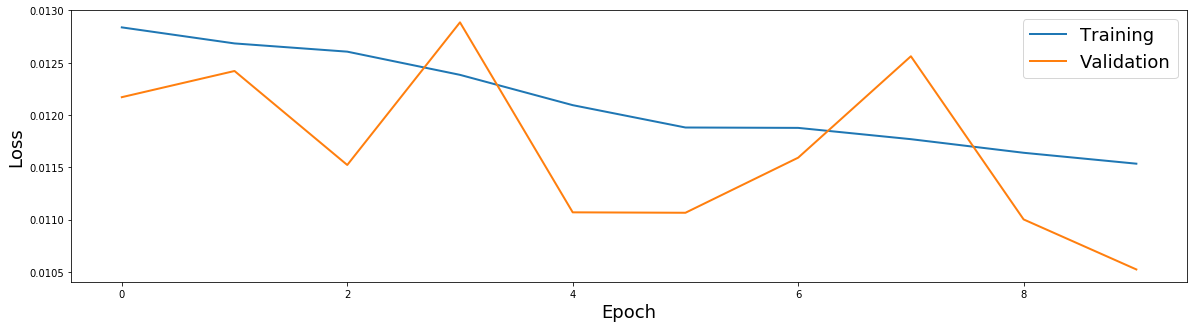

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [15]:
x_test_pred = model.predict(x_test_noise)

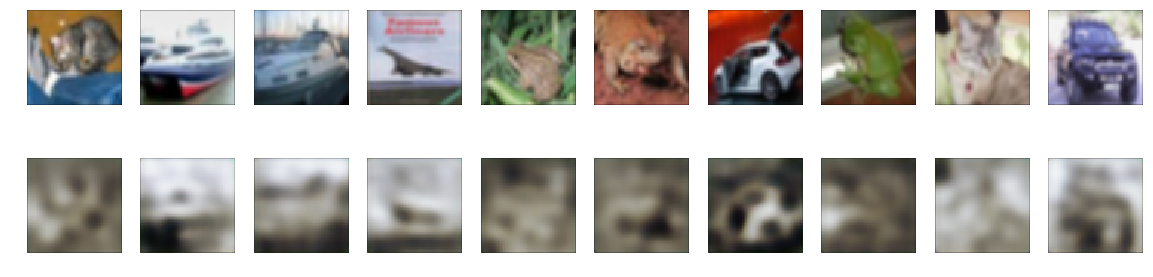

In [16]:
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()